In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
os.environ["GCR_CONFIG_SOURCE"]="files"
from astropy.cosmology import FlatLambdaCDM
import GCR
import GCRCatalogs as GCRCat
import numpy as np
import sys
ROOT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(ROOT_DIR)
import pandas as pd
from matplotlib.lines import Line2D
import itertools
from itertools import permutations 
from itertools import product 
import utils.utils as ut
import healpy as hp
# import bilby as bb


# cosmo = FlatLambdaCDM(H0=70, Om0=0.283, Tcmb0=2.725)

plt.rcParams.update({

    # --- Figure Layout ---
    "figure.figsize": (6, 4),           # Default figure size in inches
    "figure.dpi": 150,                  # DPI for crisp rendering
    "savefig.dpi": 300,                 # Higher DPI for saved figures
    "figure.autolayout": True,          # Avoids label overlap

    # --- Font & Text ---
    "font.family": "monospace",             # Or "sans-serif" for modern look
    "font.serif": ["Terminal"],  # Matches many journals
    "font.size": 12,                    # Base font size
    "axes.titlesize": 14,               # Title font size
    "axes.labelsize": 13,               # Axis label size
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "mathtext.fontset": "dejavuserif",  # Matches the serif font

    # --- Line & Marker Styles ---
    "lines.linewidth": 1.8,
    "lines.markersize": 6,
    "lines.markeredgewidth": 0.7,

    # --- Axes ---
    "axes.linewidth": 1.0,              # Frame thickness
    "axes.labelpad": 6,                 # Padding between label and axis
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "grid.linewidth": 0.7,
    "axes.spines.top": False,           # Removes top spine
    "axes.spines.right": False,         # Removes right spine

    # --- Ticks ---
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
    "xtick.top": False,
    "ytick.right": False,

    # --- Legend ---
    "legend.frameon": False,
    "legend.handlelength": 2,
    "legend.handletextpad": 0.4,
    "legend.loc": "best",

    # --- Colors and Colormaps ---
    "image.cmap": "viridis",            # Good perceptually uniform default
    "axes.prop_cycle": plt.cycler("color", [
        "#1f77b4", "#ff7f0e", "#2ca02c",
        "#d62728", "#9467bd", "#8c564b",
        "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
    ]),
})

In [2]:
NSIDE=128

In [3]:
npix = hp.nside2npix(NSIDE)

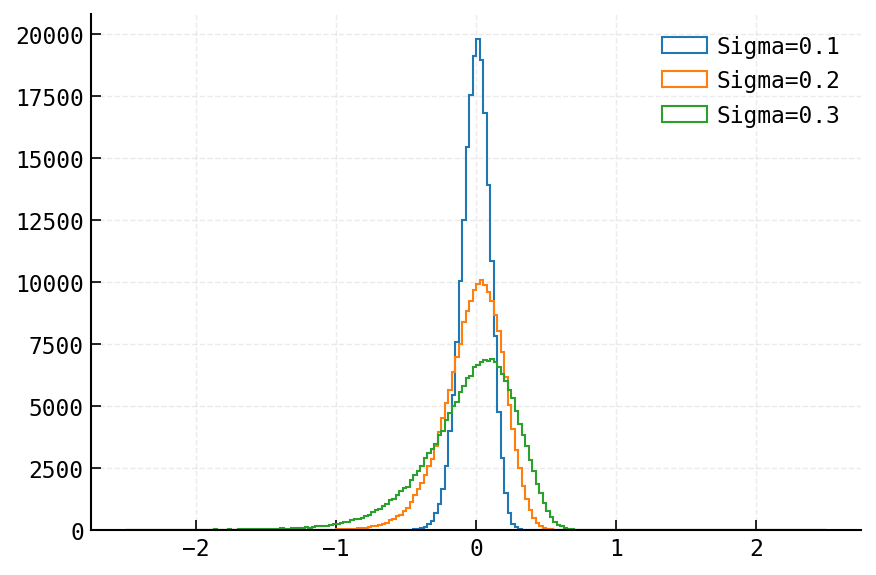

In [4]:
for sig in [0.1,0.2,0.3]:
    counts = -np.random.lognormal(mean=0,sigma=sig,size=npix)
    # counts = np.log10(counts)
    counts -= np.median(counts)
    # print(np.max(counts))
    plt.hist(counts,bins=np.arange(-2.5,2.51,step=0.025),label=f"Sigma={sig}",histtype='step')
plt.legend()

## Four cuts needed

- Mag-depth cut
- Survey uniformity cut
- z_true - z_measured adjustment for different photo-z/spec-z cases
- Cosmology adjustments to z, if needed

### Let's start with the magnitude cut

In [5]:
LSST_bands = ["u","g","r","i","z","Y"]
visits_per_yr = np.array([56, 74, 184, 187, 166, 171])/10 # visits per year in u-g-r-i-z-y

visits_dict = {}
for band,vis in zip(LSST_bands,visits_per_yr):
    visits_dict[band] = vis

expTimes = [38,30,30,30,30,30]
 
eTime_dict = {}
for band,eTime in zip(LSST_bands,expTimes):
    eTime_dict[band] = eTime

In [6]:
key_years = [1,4,7,10]
airmass = 1.2
myQuantitiesOfInterest = np.array(["redshift_true","ra_true","dec_true", # These are rest frame absolute mags, de-reddened
                                   "Mag_true_u_lsst_z0_no_host_extinction",
                                   "Mag_true_g_lsst_z0_no_host_extinction",
                                   "Mag_true_r_lsst_z0_no_host_extinction",
                                   "Mag_true_i_lsst_z0_no_host_extinction",
                                   "Mag_true_z_lsst_z0_no_host_extinction",
                                   "Mag_true_Y_lsst_z0_no_host_extinction",
                                   "galaxyID","is_central"])

In [7]:
z_step=0.025
z_max = 1.2

In [8]:
for year in key_years:
    limiting_mags = {}
    for band in LSST_bands:
        C_m,m_sky,theta_eff,k_m = ut.getLSSTBandParameters(band)
        limiting_mags[band] = ut.LSST_mag_lim(C_m,m_sky,theta_eff,eTime_dict[band]*visits_dict[band]*year,k_m,airmass)

In [9]:
cat_name2 = "skysim5000_v1.2_small"
skysimCat = GCRCat.load_catalog(cat_name2)

In [10]:
filters,filter_distribution = ut.GCR_filter_overlord(year,LSST_bands,eTime_dict,visits_dict)

In [17]:
%%time
data = pd.DataFrame(skysimCat.get_quantities(list(myQuantitiesOfInterest),filters=tuple(filters)))

CPU times: user 5.93 s, sys: 3.63 s, total: 9.56 s
Wall time: 1min 13s


In [18]:
data

,ra_true,galaxyID,Mag_true_r_lsst_z0_no_host_extinction,Mag_true_i_lsst_z0_no_host_extinction,is_central,Mag_true_g_lsst_z0_no_host_extinction,dec_true,Mag_true_Y_lsst_z0_no_host_extinction,redshift_true,Mag_true_z_lsst_z0_no_host_extinction,Mag_true_u_lsst_z0_no_host_extinction
0,62.583876,10070000000000,-19.490667,-19.641598,True,-19.170687,-40.333731,-19.774324,0.021528,-19.720839,-18.130419
1,61.398113,10070000000001,-16.130363,-16.299818,True,-15.799252,-41.036333,-16.442663,0.020944,-16.384882,-14.983802
2,60.844522,10070000000002,-19.664007,-19.851128,True,-19.306858,-40.442012,-20.023260,0.020528,-19.957903,-18.356327
3,61.418679,10070000000003,-16.518398,-16.736721,True,-16.075336,-39.964143,-16.926462,0.017873,-16.854864,-15.005349
4,61.945086,10070000000004,-17.320200,-17.488804,True,-17.022739,-39.925337,-17.655111,0.001106,-17.590200,-16.253250
...,...,...,...,...,...,...,...,...,...,...,...
6442060,66.018447,9943101895670,-18.255322,-18.240658,True,-18.289740,-39.888156,-18.242260,1.170968,-18.231886,-17.899406
6442061,65.998919,9943101895709,-19.429482,-19.456999,True,-19.368925,-39.081505,-19.483679,1.160954,-19.463242,-18.701132
6442062,65.842693,9943101895720,-18.561619,-18.528393,True,-18.628283,-37.648455,-18.506886,1.157497,-18.505604,-18.325918
6442063,65.974418,9943101895736,-17.711115,-17.520699,True,-18.002914,-39.973771,-17.316826,1.152863,-17.404568,-18.091755


In [17]:
for x in skysimCat.list_all_quantities(): 
    if x.__contains__("lsst"):
        print(x)

Mag_true_u_lsst_z0_no_host_extinction
mag_y_lsst
mag_true_y_lsst
Mag_true_r_lsst_z0
Mag_true_g_lsst_z0
Mag_true_g_lsst_z0_no_host_extinction
mag_z_lsst_no_host_extinction
Mag_true_Y_lsst_z0_no_host_extinction
mag_true_z_lsst_no_host_extinction
Mag_true_z_lsst_z0_no_host_extinction
mag_true_z_lsst
mag_z_lsst
mag_true_r_lsst_no_host_extinction
mag_true_u_lsst_no_host_extinction
mag_y_lsst_no_host_extinction
mag_Y_lsst
mag_true_i_lsst_no_host_extinction
Mag_true_i_lsst_z0_no_host_extinction
mag_g_lsst_no_host_extinction
Mag_true_y_lsst_z0_no_host_extinction
mag_true_g_lsst_no_host_extinction
Mag_true_z_lsst_z0
mag_true_r_lsst
mag_true_u_lsst
mag_true_i_lsst
mag_true_y_lsst_no_host_extinction
mag_u_lsst
Mag_true_r_lsst_z0_no_host_extinction
mag_r_lsst
mag_u_lsst_no_host_extinction
mag_true_g_lsst
Mag_true_i_lsst_z0
mag_Y_lsst_no_host_extinction
Mag_true_y_lsst_z0
mag_true_Y_lsst
mag_i_lsst_no_host_extinction
Mag_true_Y_lsst_z0
mag_g_lsst
mag_true_Y_lsst_no_host_extinction
Mag_true_u_lsst_z

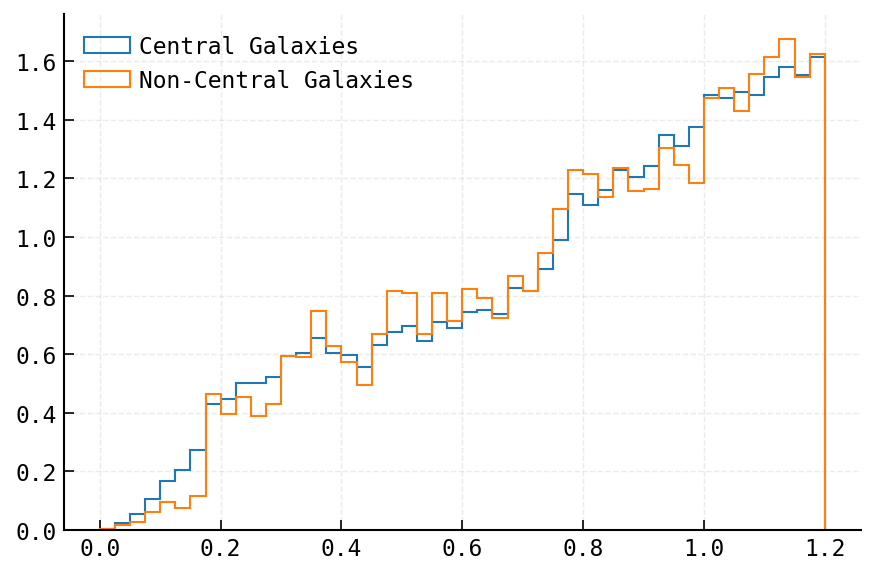

In [21]:
fig,ax = plt.subplots()

histVals = ax.hist(data[data["is_central"]==True]["redshift_true"],histtype="step",density=True,
                   bins=np.arange(0,z_max+z_step,step=z_step),label="Central Galaxies")
histVals = ax.hist(data[data["is_central"]==False]["redshift_true"],histtype="step",density=True,
                   bins=np.arange(0,z_max+z_step,step=z_step),label="Non-Central Galaxies")
ax.legend()

### Gaussian field test